# Terraform Cloud with AWS - Part 2

**Teaser:**
Join the ACME devops team on their journey to fully automated provisioning with AWS Cloud.

**Description:**

Work with the devops team at Acme Inc. as they go from manual provisioning with Terraform to a fully automated devops workflow with code reviews, testing, and automated provisioning in AWS Cloud. This workshop covers the following topics:

  * Version Control Integration
  * Role-based Access Controls
  * Sentinel Security Policies
  * Collaboration on Changes
  * Private Module Registry
  * API Driven Workflows

In [Terraform Cloud AWS Part 1](Terraform_Cloud_AWS_1.ipynb), we covered:
  * Terraform Open Source
  * Terraform Cloud
  * Remote State
  * Secure Variable Storage

## Prerequisites

* [Terraform Cloud AWS Part 1](Terraform_Cloud_AWS_1.ipynb)

### Set Main Environment Variables

In [ ]:
export RED="\e[0;31m" YELLOW="\e[0;33m" BLDYELLOW="\e[1;33m" GREEN="\e[0;32m"
export CYAN="\e[0;36m" BLUE="\e[0;34m" WHITE="\e[0;37m" BLDWHITE="\e[1;37m"
export NC="\e[0m"

printf "${GREEN}# Set MAIN_DIR for future reference.${NC}\n"
export MAIN_DIR=${PWD}

**NOTE:** Replace `TF_ORG`, `TF_WS_NAME`, `GIT_ORG` with your own values.

In [ ]:
printf "${GREEN}# Set Terraform Variables.${NC}\n"
export TF_ORG="pphan"
export TF_WS_NAME="hashicat-aws"
export TF_ADDR="https://app.terraform.io"
export TF_TOKEN=$(jq -r '.credentials."app.terraform.io".token' ${HOME}/.terraform.d/credentials.tfrc.json)
export HASHICAT_DIR="config/terraform/hashicat-aws"
export TFE_PROVIDER_DIR="config/terraform/tfe-provider"
# Get the ID of the Terraform Cloud workspace.
export TF_WS_ID=$(terraform -chdir=config/terraform/tfe-provider output -raw workspace_id)

printf "\n$MAIN_DIR \n $HASHICAT_DIR \n $TF_ADDR \n $TF_ORG \n $TF_WS_NAME \n $TF_WS_ID \n"

# Some commands may have sensitive information. Prevent commands starting with a space to be saved to shell history.
HISTCONTROL=ignoreboth # do not save lines that begin with space in history

# Working with Teams in Terraform Cloud

**Teaser:**
As your Terraform usage increases more team members want to collaborate.
Let's add some teams and access rules for our organization.

**notes:**
A few months go by and you continue building more infrastructure with Terraform Cloud. The devops team are all familiar with Terraform, but some members are unable to access the Terraform Cloud organization. Your manager Hiro steps into your cubicle with a clipboard in hand:

👨🏻‍💼Thank you for all your hard work on this Terraform project. I'd like to have read access to your workspace, and we also need to get Lars and Aisha set up. Can you please create some teams in our organization and add your co-workers to them?

Teams and role-based access controls are a paid feature of Terraform Cloud. Your instructor will need to upgrade your organization to a free trial in order to complete this challenge.

## Assignment:

Teams and role-based access controls are a paid feature of Terraform Cloud. You need to ensure your free trial has been activated from the earlier steps in order to complete this challenge.

In this challenge you'll create teams with different levels of access to your workspace. You can then invite other users to collaborate on code changes, approvals, and Terraform runs.

### Create teams with UI

1. Click on your organization's "**Settings**" tab and click on the "**Teams**" link.
2. Add a team called **admins**. 
	* Admins should be able to **Manage Policies**, **Manage Policy Overrides**, **Manage workspaces**, and **Manage VCS settings**.
	* Click the "**Update team organization access**" button after checking all 4 checkboxes.
3. Add another team called **developers**. 
	* Developers should not have any organization-wide access.
4. Add a third team called **managers**. 
	* Managers should not have any organization-wide access.

### Create teams with Provider

* We use `for_each` to loop through a set of items to create teams with no organization-wide access.
  * `for_each` [link](https://www.terraform.io/docs/language/meta-arguments/for_each.html#basic-syntax)
* `organization_access` items are `false` by default.

In [ ]:
cat > $TFE_PROVIDER_DIR/tfe-teams.tf <<EOF
locals {
  no_org_access = {
    managers = {
      manage_policies         = false
      manage_policy_overrides = false
      manage_workspaces       = false
      manage_vcs_settings     = false
    }
    developers = {
      manage_policies         = false
      manage_policy_overrides = false
      manage_workspaces       = false
      manage_vcs_settings     = false
    }
    custom = {
      manage_policies         = false
      manage_policy_overrides = false
      manage_workspaces       = false
      manage_vcs_settings     = false
    }
    admins = {
      manage_policies         = true
      manage_policy_overrides = true
      manage_workspaces       = true
      manage_vcs_settings     = true
    }
  }
}

# Create admin teams
# resource "tfe_team" "admins" {
#   organization = "${TF_ORG}"
#   name         = "admins"

#   organization_access {
#     manage_policies         = true
#     manage_policy_overrides = true
#     manage_workspaces       = true
#     manage_vcs_settings     = true
#   }
# }

# Create non-admin teams
resource "tfe_team" "${TF_ORG}_teams" {
  for_each = local.no_org_access   #toset(["managers"],["developers"])
  organization = "${TF_ORG}"
  name         = each.key
  organization_access {
    manage_policies = local.no_org_access[each.key]["manage_policies"]
    manage_policy_overrides = local.no_org_access[each.key]["manage_policy_overrides"]
    manage_workspaces = local.no_org_access[each.key]["manage_workspaces"]
    manage_vcs_settings = local.no_org_access[each.key]["manage_vcs_settings"]
  }
}
EOF

In [ ]:
terraform -chdir=$TFE_PROVIDER_DIR plan

In [ ]:
terraform -chdir=$TFE_PROVIDER_DIR apply -auto-approve

### Assign teams and rights to Workspaces with UI

Next, assign access rights to the `hashicat-aws` workspace. 

* Go into the **Settings > Team Access** page of the `hashicat-aws` workspace Settings.
	* If you don't see the **Team Access** link you might need to log out and back into Terraform Cloud.
* Give the **admins** group **admin** level access.
* Give the **developers** group **write** level access.
* Give the **managers** group **read** level access.

**[pp] Add tfe provider code as another option.**

In [ ]:
cat > $TFE_PROVIDER_DIR/tfe-team-access.tf <<EOF
locals {
  hashicat-aws_team_access = {
    admins     = "admin"
    developers = "write"
    managers = "read"
  }
}

# Create team access
resource "tfe_team_access" "workspaces" {
  for_each     = local.hashicat-aws_team_access
  team_id      = tfe_team.${TF_ORG}_teams[each.key].id
  workspace_id = tfe_workspace.hashicat_aws.id
  access       = each.value
}

# resource "tfe_team_access" "workspaces_custom" {
#   for_each     = toset(["custom"])
#   team_id      = tfe_team.${TF_ORG}_teams["custom"].id #tfe_team.admins.id 
#   workspace_id = tfe_workspace.hashicat_aws.id
#   permissions  {
#     runs           = "apply"
#     sentinel_mocks = "read"
#     state_versions = "write"
#     variables      = "write"
#     workspace_locking = true
    
#   }
# }
EOF

In [ ]:
terraform -chdir=$TFE_PROVIDER_DIR plan

In [ ]:
terraform -chdir=$TFE_PROVIDER_DIR apply -auto-approve

### Invite users

Now that you have created teams and given them workspace access, you can **invite some users to your organization**.

* Return to your **General Settings** for the **organization**, and select **Users**.
* If you're doing an instructor-led training, you can invite your instructor or a fellow student to your organization and place them on the **developers** team. 
* You'll need the email address attached to their Terraform Cloud account to invite them.
* Or you can use one of our example users below:
	* workshops+aisha@hashicorp.com
	* workshops+lars@hashicorp.com
	* workshops+hiro@hashicorp.com
* **NOTE**: You will not see any users in your organization until they accept your invitations.

⚠️ You will need at least two users (including yourself) in your organization to pass this challenge. The users you invite do not have to accept the invite to be counted.

---

### optional - Check - Teams

Confirm if you have any teams set up using the API. This step is not necessary but is useful for troubleshooting. It also illustrates how you can verify settings using the API.

In [ ]:
printf "${GREEN}# Get all team IDs in Org.${NC}\n"
curl -s -H "Authorization: Bearer $TF_TOKEN" \
    -H "Content-Type: application/vnd.api+json" \
    -X GET https://app.terraform.io/api/v2/organizations/$TF_ORG/teams \
    > $TFE_PROVIDER_DIR/tf_teams.txt

printf "${GREEN}# Get specific team IDs.${NC}\n"
ADMINS_TEAM_ID=$(cat $TFE_PROVIDER_DIR/tf_teams.txt | jq -r '.data | .[] | select(.attributes.name|test("admins")) | .id')
DEVS_TEAM_ID=$(cat $TFE_PROVIDER_DIR/tf_teams.txt | jq -r '.data | .[] | select(.attributes.name|test("developers")) | .id')
MANAGERS_TEAM_ID=$(cat $TFE_PROVIDER_DIR/tf_teams.txt | jq -r '.data | .[] | select(.attributes.name|test("managers")) | .id')
printf "${YELLOW}Team IDs: $ADMINS_TEAM_ID $DEVS_TEAM_ID $MANAGERS_TEAM_ID ${NC}\n"

printf "${GREEN}# Fetch our workspace ID.${NC}\n"
WORKSPACE_ID=$(curl -s -H "Authorization: Bearer $TF_TOKEN" -H "Content-Type: application/vnd.api+json" \
    -X GET https://app.terraform.io/api/v2/organizations/$TF_ORG/workspaces/${TF_WS_NAME} | jq -r .data.id)
printf "${YELLOW}Workspace ID: $WORKSPACE_ID ${NC}\n"

printf "${GREEN}# Check if the 'admins' team has been attached to the workspace with correct access${NC}\n"
ADMINS_ACCESS=$(curl -s --header "Authorization: Bearer $TF_TOKEN" --header "Content-Type: application/vnd.api+json" \
    --request GET "https://app.terraform.io/api/v2/team-workspaces?filter%5Bworkspace%5D%5Bid%5D=$WORKSPACE_ID" \
    | jq -r --arg ADMINS_TEAM_ID "$ADMINS_TEAM_ID" '.data | .[] | select(.relationships.team.data.id | test($ADMINS_TEAM_ID)) | .attributes.access')

[[ $ADMINS_ACCESS == admin ]] || printf "${RED}Oops, it looks like your admins group has not been set up correctly yet. Give the admins group admin rights on the hashicat-aws workspace.${NC}\n"

printf "${GREEN}# Check if the 'managers' team has been attached to the workspace with correct access${NC}\n"
MANAGERS_ACCESS=$(curl -s --header "Authorization: Bearer $TF_TOKEN" --header "Content-Type: application/vnd.api+json" \
    --request GET "https://app.terraform.io/api/v2/team-workspaces?filter%5Bworkspace%5D%5Bid%5D=$WORKSPACE_ID" \
    | jq -r --arg MANAGERS_TEAM_ID "$MANAGERS_TEAM_ID" '.data | .[] | select(.relationships.team.data.id | test($MANAGERS_TEAM_ID)) | .attributes.access')

[[ $MANAGERS_ACCESS == read ]] || printf "${RED}Oops, it looks like your managers group has not been set up correctly yet. Give the managers group read rights on the hashicat-aws workspace.${NC}\n"

printf "${GREEN}# Check if the 'developers' team has been attached to the workspace with correct access${NC}\n"
DEVS_ACCESS=$(curl -s --header "Authorization: Bearer $TF_TOKEN" --header "Content-Type: application/vnd.api+json" \
    --request GET "https://app.terraform.io/api/v2/team-workspaces?filter%5Bworkspace%5D%5Bid%5D=$WORKSPACE_ID" \
    | jq -r --arg DEVS_TEAM_ID "$DEVS_TEAM_ID" '.data | .[] | select(.relationships.team.data.id | test($DEVS_TEAM_ID)) | .attributes.access')

[[ $DEVS_ACCESS == write ]] || printf "${RED}Oops, it looks like your developers group has not been attached to your workspace yet. Give the developers group write access to the hashicat-aws workspace.${NC}\n"

printf "${GREEN}# Check the number of users in the org${NC}\n"
USERS=$(curl -s --header "Authorization: Bearer $TF_TOKEN" --header "Content-Type: application/vnd.api+json" https://app.terraform.io/api/v2/organizations/$ORG/organization-memberships | jq -r '.data | length')
printf "${YELLOW}Users: $USERS ${NC}\n"
[[ $USERS -gt 1 ]] || printf "${RED}Oops, it looks like you haven't added any other users to your organization. Invite at least one user to your org and put them on a team.${NC}\n"

### Bonus Exercise

What if you wanted to see all the variables defined in your Org or in a Workspace

The example below uses Terraform's API to show all the variables in an org that are not marked as `sensitive`. There is a `filter` for org. Then we use `jq` to only show entries where sensitive is `false`.

> NOTE: We are limiting the output to the last `30` lines to reduce the load on Jupyter Lab.

In [ ]:
curl -s -H "Authorization: Bearer ${TF_TOKEN}"\
    -H "Content-Type: application/vnd.api+json" \
    -X GET "${TF_ADDR}/api/v2/vars?filter%5Borganization%5D%5Bname%5D=${TF_ORG}" \
    | jq -rc '.data[] | select(.attributes.sensitive==false)' | tail -n 30 | jq -c 

# Version Controlled Infrastructure

**Teaser**: 
The team has grown and you need to implement code reviews. Terraform Cloud
can connect to popular Version Control Systems to enable collaboration and testing.

**Notes:**
As Terraform usage continues to increase across the organization, your team needs a better way to store and organize everyone's Terraform code. Until now you haven't had much testing or code review for infrastructure changes. Jane, the QA lead, introduces herself:

👩‍🎤 Hi sysadmin, we're trying to implement better quality assurance around our infrastructure deployment process. Can you help me add the **hashicat-aws** GitHub repository to the workspace so we can implement code reviews?"

Once you connect a VCS repository to your Terraform Cloud workspace, **all** changes to the code must be stored in the VCS before Terraform will execute them. This ensures that you have no unauthorized changes to your infrastructure as code.

In addition it allows you to enable features like code reviews, pull requests, and automated testing of your code.

## Assignment:

In order for different teams and individuals to be able to work on the same Terraform code, you need to use a Version Control System (VCS). Terraform Cloud can integrate with the most popular VCS systems including GitHub, GitLab and Bitbucket.

> **NOTE**: You will need a free GitHub.com account for this challenge. We recommend using a personal account for training instead of your work account.

### Create a fork of hashicat-aws repo

First, create a fork of the **hashicat-aws** repository. 
  * Visit this URL: https://github.com/hashicorp/hashicat-aws
  * Click on the **Fork** button in the upper right corner to create your own copy of the repo.

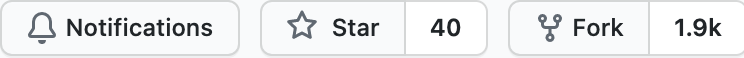

> **NOTE:** If you ran this track in the past and already forked the repository, please delete your fork and re-fork it to make sure you are using the latest version and that it does not have changes which you will push to it later in this track.

You can delete a repository by:

1. Clicking on the "**Settings**" menu of it
1. Scrolling all the way to the bottom of the page
1. Clicking the "**Delete this repository**" button in the "**Danger Zone**" section
1. Typing the full repository name
1. Then clicking the "**I understand the consequences, delete this repository**" button.

Then re-fork the repository as above.

Update your git configuration for your own repository. 

* **NOTE:** Be sure to replace `<YOURGITUSER>` and others with your own git values.

In [ ]:
# export YOURGITUSER=<YOURGITUSER>
export YOURGITUSER=phanclan
export YOURGIT_EMAIL=pphan@hashicorp.com
export YOURGIT_NAME="Peter Phan"

In [ ]:
pushd $HASHICAT_DIR

In [ ]:
git remote remove origin
git remote add origin https://github.com/${YOURGITUSER}/hashicat-aws
git pull origin master # branch might be renamed to main
git branch --set-upstream-to=origin/master master
git config --global core.editor "vi"

In [ ]:
git config --list

Next, set your email and name. Replace the values with your own.

In [ ]:
git config --global user.email "${YOURGIT_EMAIL}"
git config --global user.name "${YOURGIT_NAME}"

Sync your local repo with your fork! `commit` and `push` modified `remote_backend.tf` file.

In [ ]:
git add .
git commit -am "adding remote backend"
git push origin master

In [ ]:
popd

**NOTE:** You'll have to provide your GitHub username and password or personal access token in order to complete the `git push` command.

### Two Factor Authentication

**NOTE**: If you have two-factor authentication enabled and don't remember your personal access token,  you'll need to create a new one.

* Create a new GitHub Personal Access Token:
    * Log onto GitHub and visit the "**Tokens**" page: https://github.com/settings/tokens
    * Click on **Personal Access Tokens** and generate a new token for the workshop.
    * You can delete it afterwards if you like.
    * This token enables you to push changes from your workstation.

### Configure GitHub Access

Now that you have your own copy of the **hashicat-aws** repo to work with, follow the **Configuring GitHub Access** section of the TFC documentation to connect your GitHub account to your Terraform Organization.

https://www.terraform.io/docs/cloud/vcs/github.html

### Configure TFC workspace to use VCS Repo - UI

Once you've configured GitHub access, you can update your workspace to use your **hashicat-aws** repository as the source for all Terraform runs. 

* Configure your workspace to work with VCS
	* Go into the **Settings > Version Control** settings page for your workspace. 
	* Connect your workspace to the fork of your **hashicat-aws** repository on GitHub. 
	* Leave all the VCS settings at their defaults.
* The first VCS-backed **apply** should trigger immediately.
	* If it does not, then manually queue one up.
	* Click on the **Runs** tab to view the run in action.

### Configure TFC workspace to use VCS Repo - TF Provider

To perform this option, you need to have configured the workspace with the TF Provider from [Part 1](Terraform_Cloud_AWS_2.ipynb#Create-and-Configure-a-Workspace-with-TFE-Provider).

In [ ]:
# Get oauth client id that was created to integrate with VCS Provider
OAUTH_CLIENT_ID=$(curl -s \
  -H "Authorization: Bearer $TF_TOKEN" \
  -H "Content-Type: application/vnd.api+json" \
  -X GET \
  https://app.terraform.io/api/v2/organizations/${TF_ORG}/oauth-clients \
  | jq -r '.data | .[] | select(.attributes."service-provider"|test("github")) | .id ')

In [ ]:
cat > ${TFE_PROVIDER_DIR}/workspace-hashicat-aws.tf <<-"EOF"
data "tfe_oauth_client" "client" {
  oauth_client_id = var.vcs_oauth_client_id
}

resource "tfe_workspace" "hashicat_aws" {
  name         = "${var.tfc_hashicat_aws_workspace_name}"
  organization = var.tfc_org

  queue_all_runs = false
  execution_mode = var.execution_mode
  auto_apply = var.auto_apply
  terraform_version = var.terraform_version

  tag_names = ["boss:eljefe", "owner:pphan"] # New in Terraform Cloud

  vcs_repo {
    identifier         = var.vcs_identifier_hashicat_aws
    oauth_token_id     = data.tfe_oauth_client.client.oauth_token_id
    ingress_submodules = true
  }
}

#// TFC Variables and Outputs
variable "auto_apply" {
  description = "automatically apply changes when a Terraform plan is successful"
  default     = false
}
variable "execution_mode" {
  description = "Which execution mode to use - remote, local, agent"
  default     = "local"
}
variable "tfc_org" {
  description = "The Terraform Cloud organization to create things in"
  default     = "REPLACE_ME"
}
variable "tfc_hashicat_aws_workspace_name" {
  description = "hashicat-aws workspace name"
  default     = "hashicat-aws"
}
variable "terraform_version" {
  description = "Version of Terraform to use for this workspace."
  default     = null
}
variable "vcs_oauth_client_id" {
  description = ""
  default     = "REPLACE_ME"
}
variable "vcs_identifier_hashicat_aws" {
  description = "VCS repo org/repo"
  default     = "REPLACE_ME"
}

output "workspace_id" {
    value = tfe_workspace.hashicat_aws.id
}
EOF

Set variables.

In [ ]:
tee ${TFE_PROVIDER_DIR}/terraform.tfvars <<-EOF
auto_apply                      = true
execution_mode                  = "remote"
tfc_hashicat_aws_workspace_name = "${TF_WS_NAME}"
tfc_org                         = "${TF_ORG}"
terraform_version               = "$(terraform version -json | jq -r .terraform_version)"
vcs_identifier_hashicat_aws     = "${YOURGITUSER}/${TF_WS_NAME}"
vcs_oauth_client_id              = "${OAUTH_CLIENT_ID}"
EOF

Confirm that tfvars looks correct and that all the variables got rendered.

**Sample**
```yaml
auto_apply                      = false
execution_mode                  = "local"
tfc_hashicat_aws_workspace_name = "hashicat-aws"
tfc_org                         = "pphan"
terraform_version               = "1.0.0"
vcs_identifier_hashicat_aws     = "phanclan/hashicat-aws"
vcs_oauth_token_id              = "oc-EzWp6kr9X8tENTXr"
```

In [ ]:
terraform -chdir=${TFE_PROVIDER_DIR} apply -auto-approve

---

Congratulations, all Terraform changes must now go through version control before they are used in your workspace. 

* This enables you to do code reviews before any changes are pushed to production. 
* It provides a valuable record of any and all changes made to the code that built your infrastructure. 
* This can prevent configuration drift and undocumented changes.

**Check** your settings and let Jane know that she can clone the hashicat-aws repo for QA testing.

In [ ]:
VCS_HASHICAT=$(curl -s --header "Authorization: Bearer ${TF_TOKEN}" --header "Content-Type: application/vnd.api+json" --request GET https://app.terraform.io/api/v2/organizations/$TF_ORG/workspaces/hashicat-aws | jq -r '.data.attributes | .["vcs-repo"] | .identifier' | cut -f2 -d '/')

[[ $VCS_HASHICAT == hashicat-aws ]] && printf "${GREEN}You are good to go.${NC}" || printf "${RED}Oops, we were unable to find the hashicat-aws VCS repo connected to your workspace. Make sure you have set up GitHub integration, and updated your workspace VCS settings.${NC}"

# 👬 Collaborating with VCS

**teaser:**
Now that you've got your version control system configured with Terraform
Cloud, you can collaborate on changes to your Terraform built infrastructure.

**notes:**

The marketing team at ACME is running a special promotion next week and they need you to push a change to the **hashicat** website. If you're doing an instructor led class you can pair up with a fellow student for this exercise. Alternatively you can do the exercise on your own.

👨🏻‍🦲 Hey sysadmin friend, we need to push a change to the hashicat website. Can you please update the placeholder text with some snappy marketing slogans?

VCS-backed workspaces enable features like code reviews and automated tests that must pass before any changes can be approved for production.

## Assignment:

In this challenge you'll make a small change to the code that deploys the **hashicat-aws** application, and then create a "**Pull Request**", which is simply a way of proposing a change and optionally allowing others to review your changes.

### Change a change file in GitHub UI

Find a partner, or if you're alone you can do this exercise solo. Exchange github usernames and browse to the other person's fork of the **hashicat-aws** repository. For example:

* Go to `https://github.com/<PEER_NAME>/hashicat-aws`

In [ ]:
open https://github.com/${YOURGITUSER}/${TF_WS_NAME}

* Browse to the `files/deploy_app.sh` file and click on the small pencil icon in the upper right corner of the text area. This will allow you to edit the file right in your browser.
* Replace the following text with your own catchy marketing slogan for **ACME**.

```shell
Welcome to ${PREFIX}'s app. Replace this text with your own.
```

### Create a new branch and start a pull request

* At the bottom of the screen, select the option "**Create a new branch for this commit and start a pull request.**".
	* Click **Propose file change**.
	* Click **Create pull request**.
* Your partner should now review and approve the pull request. 
	* They will go to **<REPO> => Pull Requests**
* Or, if you're working alone you can review your own pull request and merge the changes.
	* Click **Merge pull request**, and then **Confirm merge**.
* You can delete the temporary branch. Click "**Delete branch**".

### Verify run in TFC UI

Once you've merged your changes to the master branch, watch the Terraform run that starts in the UI.

* You can do this by clicking on the **Details** link next to the hashicat-aws check on the GitHub screen. 
* This will take you straight to the speculative plan run in Terraform Cloud.

---

# Next Steps

If you no longer need this environment, proceed to the Clean Up section. Or you can go to the next part [Terraform Cloud AWS Part 3](Terraform_Cloud_AWS_3.ipynb), which will be available soon.

# Clean Up

See clean up section [here](Terraform_Cloud_AWS_1.ipynb#Clean-Up).